In [1]:
#Import libraries
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip

In [2]:
mtx = []
dist_coeff = []
CalibrationData = "wide_dist_pickle.p"
ksize = 7
#gradx_thresh = (25, 255)
#grady_thresh = (25, 255)
#mag_thresh = (25, 255)
#dir_thresh = (0, 0.09)
#hls_thresh = (125, 255)
gradx_thresh = (40, 255)
grady_thresh = (40, 255)
mag_thresh = (40, 255)
dir_thresh = (0, 0.09)
hls_thresh = (135, 255)

In [3]:
def get_ObjectAndImagePoints_for_CameraCalibration(nx, ny):
    #Prepare object points like (0,0,0), (1,0,0), (2,0,0)....(7,5,0)
    objp = np.zeros((ny*nx,3), np.float32) #Initialize object points to zeors.
    #Since Z dimension always remain 0 in 2D image, consider only 2 colums 'obj[:,:2]'. 
    #Generate coordinates using mgrid and reshape it into 48x2.
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 
    
    #Initialize two arrays to store object points and image points
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane
    
    #Identify calibration images in the folder path
    images = glob.glob('camera_cal/calibration*.jpg')
    
    #Itrate through the images as mentioned in the folder path above.
    for idx, image_name in enumerate(images):
        
        #Read the image
        img = mpimg.imread(image_name)
        #convert image into gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #find chess board corners
        retval, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if(retval == True):
            objpoints.append(objp)
            imgpoints.append(corners)
            #Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, retval)
            cv2.imwrite('./output_images/CameraCalibration/corners_found' + str(idx) + '.jpg', img)
    return(objpoints,imgpoints) #End of function 'get_ObjectAndImagePoints_for_CameraCalibration()'

In [4]:
def CalibrateCamera_and_undistortImage(img, objpoints, imgpoints):
    #perform camera calibration
    retval, mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    return cv2.undistort(img, mtx, dist_coeff, None, mtx)

In [5]:
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    #Calculate directional(x, and y) gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x = 1 if orient == 'x' else 0
    y = 1 if orient == 'y' else 0
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    sobel_scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #apply threshold
    grad_binary = np.zeros_like(sobel_scaled)
    grad_binary[(sobel_scaled>=thresh[0]) & (sobel_scaled<=thresh[1])] = 1
    return grad_binary

def mag_threshold(img, sobel_kernel=3, thresh=(0,255)):
    #Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    magnitude = np.sqrt(np.add(np.square(sobelx), np.square(sobely)))
    sobel_scaled = np.uint8(255*magnitude/np.max(magnitude))
    #apply threshold
    mag_binary = np.zeros_like(sobel_scaled)
    mag_binary[(sobel_scaled>=thresh[0]) & (sobel_scaled<=thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    #Calculate gradient binary
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobelx, abs_sobely)
    #apply threshold
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction>=thresh[0]) & (direction<=thresh[1])] = 1    
    return dir_binary

def gradient_threshold(img):
    #get gradient x, y binary, magnitude binary, direction binary
    gradx_binary = abs_sobel_threshold(img, orient='x', sobel_kernel=ksize, thresh=gradx_thresh)
    grady_binary = abs_sobel_threshold(img, orient='y', sobel_kernel=ksize, thresh=grady_thresh)
    mag_binary = mag_threshold(img, sobel_kernel=ksize, thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)
    
    #Combine Threshold
    combined = np.zeros_like(dir_binary)
    combined[((gradx_binary==1)&(grady_binary==1)) | ((mag_binary==1)&(dir_binary==1))] = 1
    
    return combined

def hls_threshold(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_channel>=thresh[0]) & (s_channel<=thresh[1])] = 1
    return color_binary

def color_gradient_threshold(img):
    #apply color gradient (s_channel)
    hls_binary = hls_threshold(img, thresh=hls_thresh)
    #get gradient x, y binary, magnitude binary, direction binary
    gradx_binary = abs_sobel_threshold(img, orient='x', sobel_kernel=ksize, thresh=gradx_thresh)
    grady_binary = abs_sobel_threshold(img, orient='y', sobel_kernel=ksize, thresh=grady_thresh)
    mag_binary = mag_threshold(img, sobel_kernel=ksize, thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)
    
    #combined threshold
    color_binary = np.dstack((np.zeros_like(dir_binary), dir_binary, dir_binary))*255
    gradient_binary = np.zeros_like(dir_binary)
    gradient_binary[((gradx_binary==1)&(grady_binary==1)) | ((mag_binary==1)&(dir_binary==1))] = 1
    combined = np.zeros_like(dir_binary)
    combined[(gradx_binary==1) | (hls_binary==1)] = 1
    return combined
    

def region_of_interest(img):
    #set vertices for the mask
    imageshape = img.shape
    left_bottom = (0.15*imageshape[1], imageshape[0])
    left_top = (0.45*imageshape[1], 0.60*imageshape[0])
    right_top = (0.60*imageshape[1], 0.60*imageshape[0])
    right_bottom = (0.90*imageshape[1], imageshape[0])
    
    vertices = np.array([[left_bottom,left_top,right_top,right_bottom]], dtype=np.int32)
    
    #define a blank mask
    mask = np.zeros_like(img)
    
    if(len(img.shape)>2):
        channel_count = img.shape[2]
        ignoreMaskColor = (255,)*channel_count
    else:
        ignoreMaskColor = 255
        
    #fill pixels inside the polygon defined by vertices with the fill color
    cv2.fillPoly(mask, vertices, ignoreMaskColor)
    
    #return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def perspactive_transform(img):
    #select and source and destination points from the image.
    src = np.float32([[519, 502], [765, 502], [1029, 668], [275, 668]])
    dst = np.float32([[275, 502], [1029, 502], [1029, 668], [275, 668]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    #return cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return (cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR), Minv)

def sliding_windows_polyfit(img):
    #compute the histogram of the lower half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    #Create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((img, img, img))*255)
    #Separate the left part of the histogram from the right
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #split the image in 9 horizontal strips
    total_windows = 9
    #set height of window
    SingleWindowHeight = img.shape[0]//total_windows
    
    #set width of the windows +/- margin
    margin = 100
    #set minimum number of pixels found to recenter window
    minpix = 50
    #get indices of all nonzero pixels along x and y axis
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    #current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    #create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #step through the window one by one
    for window in range(total_windows):
        #compute the windows boundary
        win_y_low = img.shape[0] - (window+1)*SingleWindowHeight
        win_y_high = img.shape[0] - window*SingleWindowHeight
        win_leftx_low = leftx_current - margin
        win_leftx_high = leftx_current + margin
        win_rightx_low = rightx_current - margin
        win_rightx_high = rightx_current + margin
        
        #Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_leftx_low, win_y_low), (win_leftx_high, win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_rightx_low, win_y_low), (win_rightx_high, win_y_high), (0,0,255), 2)
        
        #identify nonzero pixels within left and right window
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_leftx_low) & (nonzerox<win_leftx_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_rightx_low) & (nonzerox<win_rightx_high)).nonzero()[0]
        
        #append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If nonzero peixels are greater than minpix, recenter the next window on their mean
        if (len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

    #concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Display left lane in red and right lane in blue
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0,0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,255,0]
    plt.imshow(out_img)
    
    #generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    plt.plot(left_fitx, ploty, color = 'yellow')
    plt.plot(right_fitx, ploty, color = 'yellow')
    plt.xlim(0,1280)
    plt.ylim(720,0)
    plt.savefig('./output_images/sliding_window_polyfit.jpg')
    plt.show()
    return (ploty, left_fitx, right_fitx)
    
    
def save_image_transform(InputImage, transformedImage, is_colored, is_gray, image_name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
    if(is_colored == True):
        ax1.imshow(InputImage)
    else:
        ax1.imshow(InputImage, cmap='gray')
    if(is_gray == True):
        ax2.imshow(transformedImage, cmap='gray')
    else:
        ax2.imshow(transformedImage)
    
    ax1.set_title('Input Image', fontsize = 20)
    ax2.set_title('Transformed Image', fontsize = 20)
    plt.savefig('./output_images/' + image_name + '.jpg')
    plt.show()

def pipeline_AdvancedLaneLines(img):
    #Step1: Distortion Correction
    print("Step1: Undistort the input image...")
    img_undistorted = cv2.undistort(img, mtx, dist_coeff, None, mtx)
    save_image_transform(img, img_undistorted,True, False, 'undistorted')
        
    #Step2: Gradient Threshold
    print("Step2: Applying Gradient threshold to the undistorted image...")
    gradient = color_gradient_threshold(img_undistorted)
    save_image_transform(img_undistorted, gradient, False, True, 'color_gradient')
    
    #Step3: Region of interest
    print("Step3: Selecting region of interest from the gradient image...")
    masked_image = region_of_interest(gradient)
    save_image_transform(gradient, masked_image,False, True, 'masked_image')    
    
    #Step4: perspective transform
    print("Step4: Performing perspective transform on the masked image...")
    warped, Minv = perspactive_transform(masked_image)
    save_image_transform(masked_image, warped,False, True, 'perspective')  
    
    #Step5: Detect Lines
    print("Step5: Applying sliding window filter on the warped image....")
    ploty, left_fitx, right_fitx = sliding_windows_polyfit(warped)
    
    print("All steps of the pipeline are completed!")
    return (warped, Minv, ploty, left_fitx, right_fitx)

def draw_lane(warped, Minv, ploty, left_fitx, right_fitx):
    #Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #Recaste the x and y points in to usable format for cv2.fillpoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    #Draw the lane into the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    #warp the blank back to original image shape using inverse perspective matrix (Minv)
    newWarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    #combine the result with the original image
    result = cv2.addWeighted(img, 1, newWarp, 0.2, 0)
    return result

Reading camera matrix and distortion coefficients from the 'CalibrationData' file...
Step1: Undistort the input image...


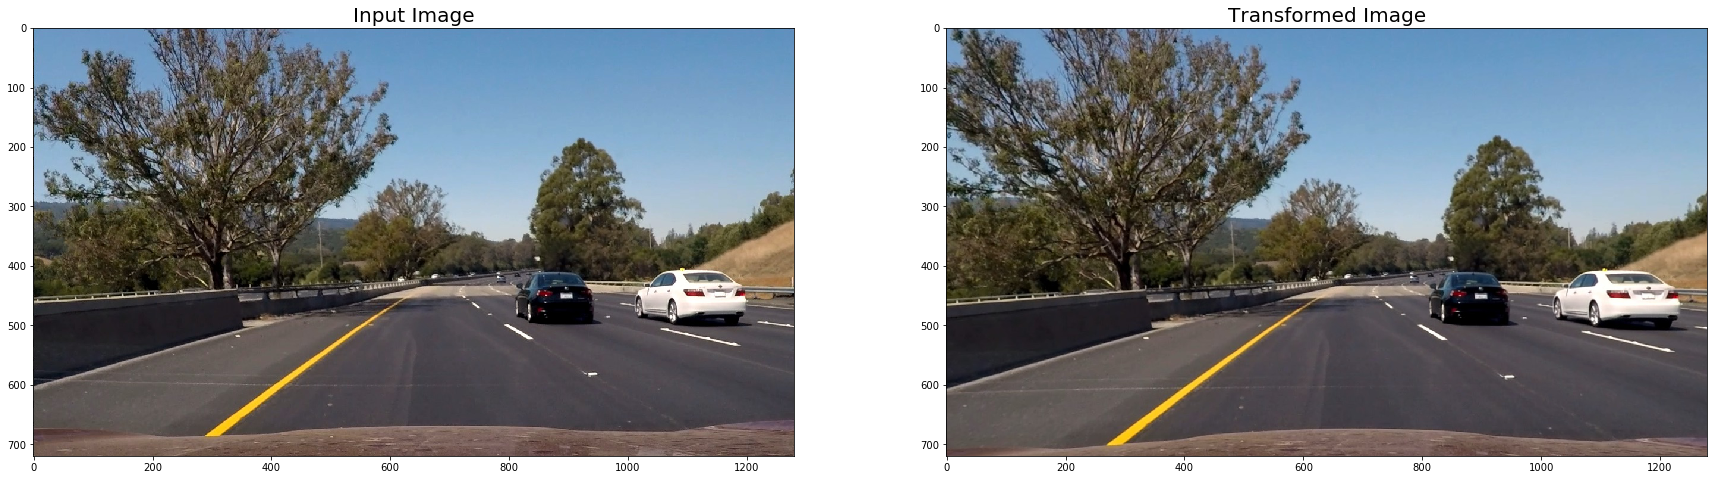

Step2: Applying Gradient threshold to the undistorted image...


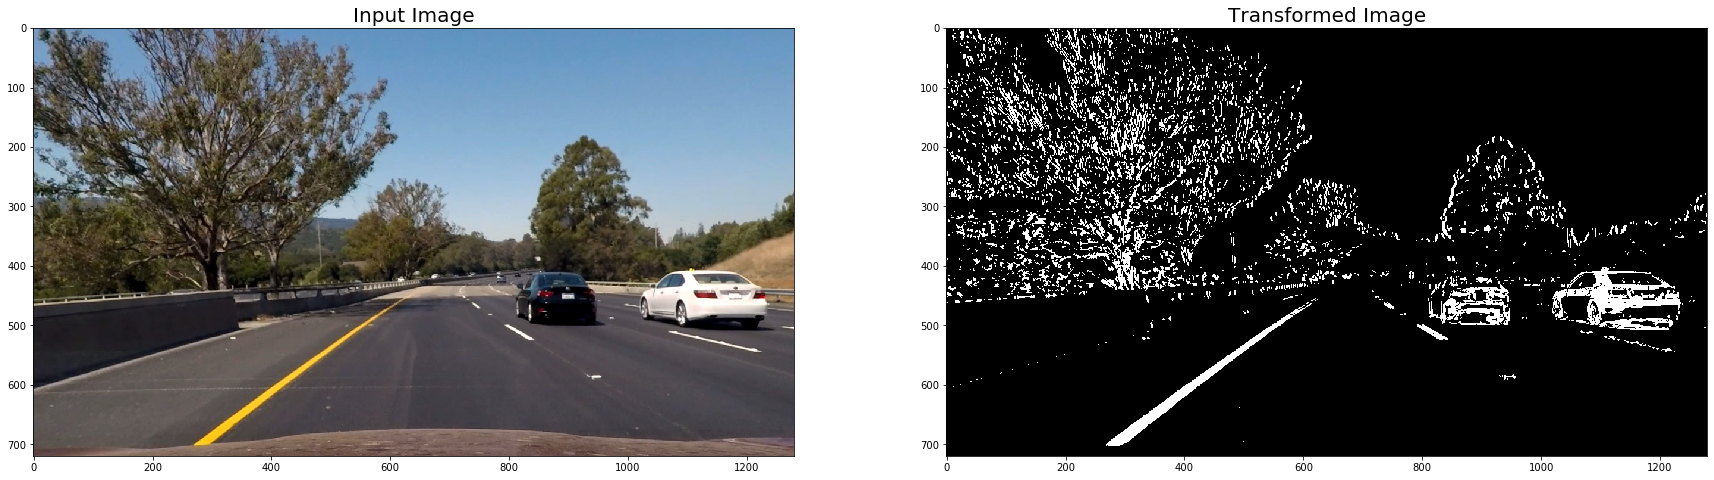

Step3: Selecting region of interest from the gradient image...


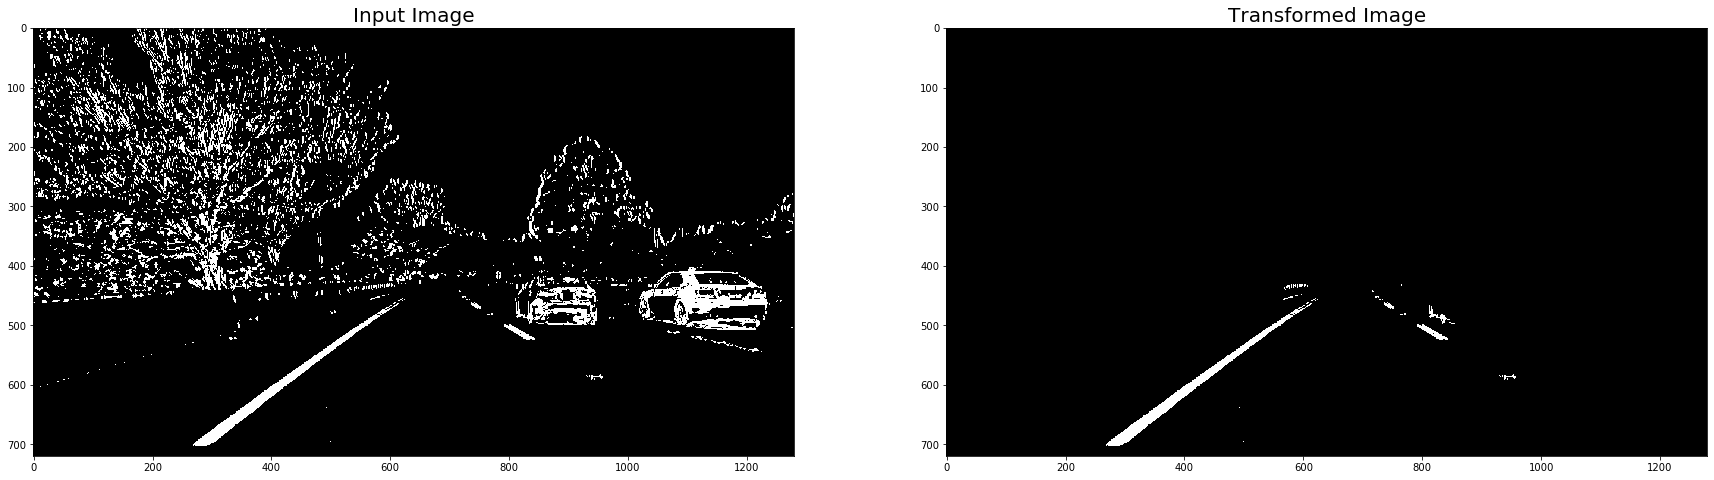

Step4: Performing perspective transform on the masked image...


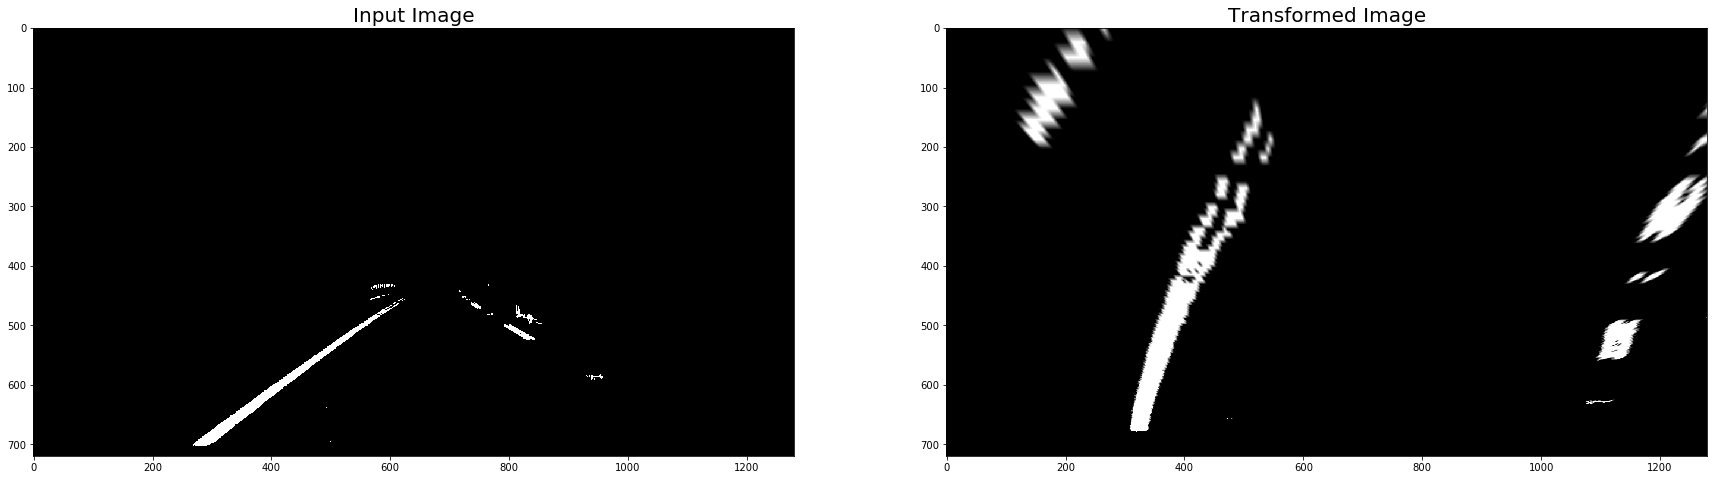

Step5: Applying sliding window filter on the warped image....


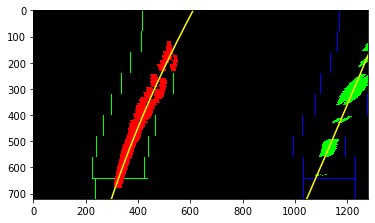

All steps of the pipeline are completed!


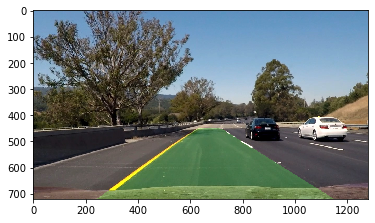

In [6]:
if __name__ == '__main__':
    #Creat a directory 'CameraCalibration' under 'output_images'
    output_dir = "output_images/CameraCalibration"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    #get the object points and image points
    if os.path.exists(CalibrationData):
        print("Reading camera matrix and distortion coefficients from the 'CalibrationData' file...")
        Read_CalibrationData = pickle.load(open(CalibrationData, "rb"))
        mtx = Read_CalibrationData["mtx"]
        dist_coeff = Read_CalibrationData["dist"]
    else:
        print("Calibrating camera...")
        #get the object points and image points
        objpoints, imgpoints = get_ObjectAndImagePoints_for_CameraCalibration(9, 6)
    
        #Read an image for testing
        img = mpimg.imread("test_images/test5.jpg")
        #Calibrate the image and then undistort
        retval, mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
        Read_CalibrationData = {}
        Read_CalibrationData["mtx"] = mtx #save mtx for later use.
        Read_CalibrationData["dist"] = dist_coeff #save dist_coeff for later use.
        pickle.dump(Read_CalibrationData, open(CalibrationData, "wb"))  
    
    #Apply pipeline
    img = mpimg.imread("test_images/test6.jpg")
    #pipeline_AdvancedLaneLines(img)
    warped, Minv, ploty, left_fitx, right_fitx = pipeline_AdvancedLaneLines(img)
    
    # Display lane on to the road
    result = draw_lane(warped, Minv, ploty, left_fitx, right_fitx)
    plt.imshow(result)
    plt.savefig('./output_images/result.jpg')
    plt.show()